# **Construcción, Ajuste y Evaluación de Modelos de Machine Learning**
# **Online News Popularity Dataset**

---

## **Proyecto MLOps - Predicción de Popularidad de Artículos Online**

### **Objetivo:**
Construir, ajustar y evaluar modelos de Machine Learning para predecir el número de compartidos (`shares`) de artículos de noticias online utilizando técnicas y algoritmos apropiados al problema de regresión.

### **Dataset:**
UCI Online News Popularity Data Set  
https://www.kaggle.com/datasets/thehapyone/uci-online-news-popularity-data-set

**Características:**
- 61 atributos (58 predictivos, 2 no predictivos, 1 variable objetivo)
- Variable objetivo: `shares` (número de veces que se compartió el artículo)
- Tipo de problema: **Regresión**

---

### **Estructura del Notebook:**
1. **Análisis del Problema y Configuración**
2. **Carga y Exploración de Datos**
3. **Preprocesamiento Modularizado**
4. **Selección de Modelos y Justificación**
5. **Entrenamiento y Ajuste de Hiperparámetros**
6. **Evaluación con Curvas de Aprendizaje**
7. **Comparación de Modelos**
8. **Conclusiones y Reflexión**


## **1. Análisis del Problema**

### **1.1 Descripción del Problema**

El problema consiste en predecir la popularidad de artículos de noticias online, medida por el número de veces que fueron compartidos (`shares`). Este es un problema de **regresión** donde:

- **Variable objetivo:** `shares` (continua, con sesgo positivo)
- **Variables predictoras:** 58 atributos que incluyen:
  - Características del contenido (tokens, palabras, longitud)
  - Características de enlaces e imágenes
  - Análisis de sentimiento y subjetividad
  - Características temporales (día de la semana)
  - Tópicos LDA
  - Canal de publicación

### **1.2 Características del Dataset**

**Variables No Predictivas:**
- `url`: URL del artículo
- `timedelta`: Días entre publicación y adquisición del dataset

**Variables Predictivas Principales:**
- Contenido: `n_tokens_title`, `n_tokens_content`, `n_unique_tokens`
- Multimedia: `num_imgs`, `num_videos`, `num_hrefs`
- Sentimiento: `global_sentiment_polarity`, `title_sentiment_polarity`
- Temporales: `weekday_is_*` (lunes a domingo)
- Canales: `data_channel_is_*` (lifestyle, entertainment, bus, socmed, tech, world)
- Tópicos: `LDA_00` a `LDA_04`

### **1.3 Desafíos del Problema**

1. **Distribución sesgada:** La variable `shares` típicamente tiene una distribución con sesgo positivo (requiere transformación)
2. **Alta dimensionalidad:** 58 features predictoras
3. **Variables categóricas:** Encoded como one-hot (weekday, data_channel)
4. **Escalas diferentes:** Variables requieren normalización
5. **Datos preprocesados:** Ya vienen estandarizados/normalizados


## **2. Configuración e Importación de Librerías**


In [1]:
# Importación de librerías esenciales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn: Preprocesamiento
from sklearn.model_selection import train_test_split, learning_curve, cross_validate
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline

# Scikit-learn: Modelos
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

# XGBoost
try:
    from xgboost import XGBRegressor
    XGBOOST_AVAILABLE = True
except ImportError:
    print("XGBoost no disponible. Instalar con: pip install xgboost")
    XGBOOST_AVAILABLE = False

# Scikit-learn: Métricas
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score,
    mean_absolute_percentage_error
)

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✓ Librerías importadas correctamente")
print(f"✓ XGBoost disponible: {XGBOOST_AVAILABLE}")

XGBoost no disponible. Instalar con: pip install xgboost
✓ Librerías importadas correctamente
✓ XGBoost disponible: False


## **3. Funciones Modulares para MLOps**

### **Estas funciones pueden ser exportadas a scripts para automatización**


In [2]:
# =====================================================================
# MÓDULO: DATA LOADING
# =====================================================================

def load_online_news_data(filepath: str, drop_non_predictive: bool = True) -> pd.DataFrame:
    """
    Carga el dataset de online news popularity.
    
    Args:
        filepath: Ruta al archivo CSV
        drop_non_predictive: Si True, elimina columnas no predictivas (url, timedelta)
    
    Returns:
        DataFrame con los datos cargados
    """
    print(f"Cargando datos desde: {filepath}")
    
    # Cargar datos
    df = pd.read_csv(filepath, index_col=0)
    
    print(f"✓ Datos cargados: {df.shape[0]} registros, {df.shape[1]} columnas")
    
    # Eliminar columnas no predictivas
    if drop_non_predictive:
        non_predictive_cols = ['url', 'timedelta']
        cols_to_drop = [col for col in non_predictive_cols if col in df.columns]
        if cols_to_drop:
            df = df.drop(columns=cols_to_drop)
            print(f"✓ Columnas no predictivas eliminadas: {cols_to_drop}")
    
    return df


def split_features_target(df: pd.DataFrame, target_col: str = 'shares'):
    """
    Separa features y variable objetivo.
    
    Args:
        df: DataFrame completo
        target_col: Nombre de la columna objetivo
    
    Returns:
        X (features), y (target)
    """
    if target_col not in df.columns:
        raise ValueError(f"Columna objetivo '{target_col}' no encontrada en el dataset")
    
    X = df.drop(columns=[target_col])
    y = df[[target_col]]
    
    print(f"✓ Features: {X.shape[1]} columnas")
    print(f"✓ Target: {target_col}")
    
    return X, y


def analyze_target_distribution(y: pd.DataFrame, target_col: str = 'shares'):
    """
    Analiza la distribución de la variable objetivo.
    
    Args:
        y: DataFrame con la variable objetivo
        target_col: Nombre de la columna objetivo
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Original
    axes[0].hist(y[target_col], bins=50, edgecolor='black', alpha=0.7)
    axes[0].set_title('Distribución Original de Shares')
    axes[0].set_xlabel('Shares')
    axes[0].set_ylabel('Frecuencia')
    
    # Log transform
    y_log = np.log1p(y[target_col])  # log(1 + x) para evitar log(0)
    axes[1].hist(y_log, bins=50, edgecolor='black', alpha=0.7, color='orange')
    axes[1].set_title('Distribución Log-Transformada')
    axes[1].set_xlabel('log(1 + Shares)')
    axes[1].set_ylabel('Frecuencia')
    
    # Boxplot
    axes[2].boxplot([y[target_col]], labels=['Shares'])
    axes[2].set_title('Boxplot de Shares (Outliers)')
    axes[2].set_ylabel('Shares')
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas
    print("\n" + "="*60)
    print("ESTADÍSTICAS DE LA VARIABLE OBJETIVO")
    print("="*60)
    print(f"Media: {y[target_col].mean():.2f}")
    print(f"Mediana: {y[target_col].median():.2f}")
    print(f"Desv. Estándar: {y[target_col].std():.2f}")
    print(f"Mínimo: {y[target_col].min():.2f}")
    print(f"Máximo: {y[target_col].max():.2f}")
    print(f"Skewness: {y[target_col].skew():.2f}")
    print("="*60)


In [3]:
# =====================================================================
# MÓDULO: DATA SPLITTING
# =====================================================================

def split_train_val_test(X, y, train_size=0.7, val_size=0.15, test_size=0.15, 
                         random_state=42):
    """
    Divide los datos en conjuntos de entrenamiento, validación y prueba.
    
    Args:
        X: Features
        y: Target
        train_size: Proporción para entrenamiento
        val_size: Proporción para validación
        test_size: Proporción para prueba
        random_state: Semilla aleatoria
    
    Returns:
        X_train, X_val, X_test, y_train, y_val, y_test
    """
    assert abs(train_size + val_size + test_size - 1.0) < 0.01, \
        "Las proporciones deben sumar 1.0"
    
    # Primera división: train vs (val + test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, 
        train_size=train_size, 
        random_state=random_state,
        shuffle=True
    )
    
    # Segunda división: val vs test
    val_ratio = val_size / (val_size + test_size)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        train_size=val_ratio,
        random_state=random_state,
        shuffle=True
    )
    
    print("\n" + "="*60)
    print("DIVISIÓN DE DATOS")
    print("="*60)
    print(f"Train: {X_train.shape[0]} muestras ({train_size*100:.1f}%)")
    print(f"Val:   {X_val.shape[0]} muestras ({val_size*100:.1f}%)")
    print(f"Test:  {X_test.shape[0]} muestras ({test_size*100:.1f}%)")
    print(f"Total: {X_train.shape[0] + X_val.shape[0] + X_test.shape[0]} muestras")
    print("="*60)
    
    return X_train, X_val, X_test, y_train, y_val, y_test


In [4]:
# =====================================================================
# MÓDULO: TARGET TRANSFORMATION
# =====================================================================

def apply_log_transform(y_train, y_val, y_test, target_col='shares'):
    """
    Aplica transformación logarítmica a la variable objetivo.
    
    Args:
        y_train, y_val, y_test: DataFrames con la variable objetivo
        target_col: Nombre de la columna objetivo
    
    Returns:
        y_train_log, y_val_log, y_test_log
    """
    print("\n" + "="*60)
    print("TRANSFORMACIÓN LOGARÍTMICA DE LA VARIABLE OBJETIVO")
    print("="*60)
    
    # Aplicar log(1 + x) para evitar problemas con valores de 0
    y_train_log = np.log1p(y_train[target_col])
    y_val_log = np.log1p(y_val[target_col])
    y_test_log = np.log1p(y_test[target_col])
    
    print(f"✓ Transformación aplicada: log(1 + shares)")
    print(f"  Desv. Std. Original (train): {y_train[target_col].std():.3f}")
    print(f"  Desv. Std. Log (train): {y_train_log.std():.3f}")
    print("="*60)
    
    return y_train_log, y_val_log, y_test_log


def calculate_baseline_rmse(y_train_log):
    """
    Calcula el RMSE baseline (desviación estándar).
    
    Este es el valor de referencia para determinar si un modelo está subentrenado.
    Un modelo debe tener RMSE < baseline para no estar subentrenado.
    
    Args:
        y_train_log: Variable objetivo transformada (train)
    
    Returns:
        baseline_rmse: Valor de referencia
    """
    baseline_rmse = y_train_log.std()
    
    print("\n" + "="*60)
    print("BASELINE RMSE (Criterio de Subentrenamiento)")
    print("="*60)
    print(f"Desviación Estándar (train_log): {baseline_rmse:.4f}")
    print(f"\n⚠️  Un modelo con RMSE > {baseline_rmse:.4f} está SUBENTRENADO")
    print("="*60)
    
    return baseline_rmse


In [5]:
# =====================================================================
# MÓDULO: MODEL SELECTION & JUSTIFICATION
# =====================================================================

def get_model_configurations():
    """
    Define las configuraciones de modelos a evaluar con su justificación.
    
    Returns:
        Dictionary con configuraciones de modelos
    """
    models = {
        'ridge': {
            'name': 'Ridge Regression',
            'model': Ridge(random_state=42),
            'params': {
                'alpha': 1.0
            },
            'justification': """
            - Regresión lineal con regularización L2
            - Maneja multicolinealidad entre features
            - Baseline rápido para problemas de regresión
            - Apropiado cuando hay muchas features correlacionadas
            """
        },
        
        'random_forest': {
            'name': 'Random Forest',
            'model': RandomForestRegressor(random_state=42, n_jobs=-1),
            'params': {
                'n_estimators': 100,
                'max_depth': 10,
                'min_samples_split': 5,
                'min_samples_leaf': 2
            },
            'justification': """
            - Ensemble de árboles de decisión
            - Maneja relaciones no lineales y features categóricas
            - Robusto a outliers y no requiere normalización
            - Proporciona importancia de features
            - Apropiado para datasets con alta dimensionalidad
            """
        },
        
        'gradient_boosting': {
            'name': 'Gradient Boosting',
            'model': GradientBoostingRegressor(random_state=42),
            'params': {
                'n_estimators': 100,
                'learning_rate': 0.1,
                'max_depth': 5,
                'min_samples_split': 5
            },
            'justification': """
            - Ensemble secuencial que corrige errores iterativamente
            - Excelente rendimiento en problemas de regresión complejos
            - Maneja relaciones no lineales complejas
            - Más preciso que Random Forest pero más lento
            """
        },
        
        'mlp': {
            'name': 'MLP Neural Network',
            'model': MLPRegressor(random_state=42, max_iter=1000, early_stopping=True),
            'params': {
                'hidden_layer_sizes': (100, 50),
                'activation': 'relu',
                'alpha': 0.001,
                'learning_rate': 'adaptive'
            },
            'justification': """
            - Red neuronal multicapa (Perceptrón Multicapa)
            - Captura patrones complejos y no lineales
            - Flexible para diferentes arquitecturas
            - Apropiado cuando hay suficientes datos (>10k muestras)
            - Requiere normalización de features
            """
        }
    }
    
    # Agregar XGBoost si está disponible
    if XGBOOST_AVAILABLE:
        models['xgboost'] = {
            'name': 'XGBoost',
            'model': XGBRegressor(random_state=42, n_jobs=-1),
            'params': {
                'n_estimators': 100,
                'learning_rate': 0.1,
                'max_depth': 5,
                'min_child_weight': 3,
                'subsample': 0.8
            },
            'justification': """
            - Gradient boosting optimizado y eficiente
            - Estado del arte en competencias de ML
            - Maneja missing values automáticamente
            - Regularización incorporada (L1 y L2)
            - Excelente balance velocidad/precisión
            """
        }
    
    return models


def print_model_justifications(models):
    """
    Imprime las justificaciones de selección de modelos.
    
    Args:
        models: Dictionary de configuraciones de modelos
    """
    print("\n" + "="*70)
    print("SELECCIÓN Y JUSTIFICACIÓN DE ALGORITMOS DE MACHINE LEARNING")
    print("="*70)
    print("\nProblema: Regresión - Predicción de Shares (variable continua)")
    print("Dataset: ~40k muestras, 58 features, distribución sesgada\n")
    
    for i, (key, config) in enumerate(models.items(), 1):
        print(f"\n{i}. {config['name']}")
        print("-" * 70)
        print(f"Justificación:{config['justification']}")
        print(f"Hiperparámetros iniciales: {config['params']}")
    
    print("\n" + "="*70)


In [6]:
# =====================================================================
# MÓDULO: MODEL TRAINING
# =====================================================================

def create_pipeline(model, scaler=None):
    """
    Crea un pipeline de sklearn con preprocesamiento y modelo.
    
    Args:
        model: Modelo de sklearn
        scaler: Scaler a usar (None, 'standard', 'robust')
    
    Returns:
        Pipeline de sklearn
    """
    steps = []
    
    if scaler == 'standard':
        steps.append(('scaler', StandardScaler()))
    elif scaler == 'robust':
        steps.append(('scaler', RobustScaler()))
    
    steps.append(('model', model))
    
    return Pipeline(steps)


def train_model(model, X_train, y_train, model_name="Model"):
    """
    Entrena un modelo y reporta el tiempo de entrenamiento.
    
    Args:
        model: Modelo o pipeline de sklearn
        X_train: Features de entrenamiento
        y_train: Target de entrenamiento
        model_name: Nombre del modelo para logging
    
    Returns:
        Modelo entrenado
    """
    import time
    
    print(f"\nEntrenando {model_name}...", end=" ")
    start_time = time.time()
    
    model.fit(X_train, y_train)
    
    elapsed_time = time.time() - start_time
    print(f"✓ Completado en {elapsed_time:.2f}s")
    
    return model


def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, 
                   model_name="Model", baseline_rmse=None):
    """
    Evalúa un modelo en train, val y test con múltiples métricas.
    
    Args:
        model: Modelo entrenado
        X_train, y_train: Datos de entrenamiento
        X_val, y_val: Datos de validación
        X_test, y_test: Datos de prueba
        model_name: Nombre del modelo
        baseline_rmse: RMSE baseline para comparación
    
    Returns:
        Dictionary con métricas
    """
    # Predicciones
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    
    # Calcular métricas
    metrics_dict = {
        'train': {
            'rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'mae': mean_absolute_error(y_train, y_train_pred),
            'r2': r2_score(y_train, y_train_pred)
        },
        'val': {
            'rmse': np.sqrt(mean_squared_error(y_val, y_val_pred)),
            'mae': mean_absolute_error(y_val, y_val_pred),
            'r2': r2_score(y_val, y_val_pred)
        },
        'test': {
            'rmse': np.sqrt(mean_squared_error(y_test, y_test_pred)),
            'mae': mean_absolute_error(y_test, y_test_pred),
            'r2': r2_score(y_test, y_test_pred)
        }
    }
    
    # Imprimir resultados
    print(f"\n{'='*70}")
    print(f"EVALUACIÓN: {model_name}")
    print(f"{'='*70}")
    
    if baseline_rmse is not None:
        print(f"Baseline RMSE (subentrenamiento): {baseline_rmse:.4f}\n")
    
    print(f"{'Conjunto':<10} {'RMSE':<12} {'MAE':<12} {'R²':<12} {'Estado':<20}")
    print("-" * 70)
    
    for dataset_name in ['train', 'val', 'test']:
        m = metrics_dict[dataset_name]
        
        # Determinar estado
        status = ""
        if baseline_rmse is not None and dataset_name == 'train':
            if m['rmse'] > baseline_rmse:
                status = "⚠️ SUBENTRENADO"
            else:
                status = "✓ OK"
        
        print(f"{dataset_name.capitalize():<10} {m['rmse']:<12.4f} {m['mae']:<12.4f} "
              f"{m['r2']:<12.4f} {status:<20}")
    
    # Gap entre train y val (sobreentrenamiento)
    gap = metrics_dict['train']['rmse'] - metrics_dict['val']['rmse']
    print(f"\nGap Train-Val RMSE: {gap:.4f}", end="")
    
    if abs(gap) > 0.05:
        if gap < 0:
            print(" ⚠️ Posible SOBREENTRENAMIENTO")
        else:
            print(" ⚠️ Revisar")
    else:
        print(" ✓ Buena generalización")
    
    print("="*70)
    
    return metrics_dict


In [7]:
# =====================================================================
# MÓDULO: LEARNING CURVES
# =====================================================================

def plot_learning_curves(model, X_train, y_train, model_name="Model", 
                         cv=5, baseline_rmse=None, n_jobs=-1):
    """
    Genera y visualiza las curvas de aprendizaje para detectar sub/sobreentrenamiento.
    
    Args:
        model: Modelo o pipeline de sklearn
        X_train: Features de entrenamiento
        y_train: Target de entrenamiento
        model_name: Nombre del modelo
        cv: Número de folds para validación cruzada
        baseline_rmse: RMSE baseline para referencia
        n_jobs: Número de trabajos paralelos
    """
    print(f"\nGenerando curvas de aprendizaje para {model_name}...")
    
    # Calcular curvas de aprendizaje
    train_sizes, train_scores, val_scores = learning_curve(
        estimator=model,
        X=X_train,
        y=y_train,
        cv=cv,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='neg_mean_squared_error',
        n_jobs=n_jobs,
        random_state=42
    )
    
    # Convertir MSE a RMSE
    train_scores_rmse = np.sqrt(-train_scores)
    val_scores_rmse = np.sqrt(-val_scores)
    
    # Calcular medias y desviaciones estándar
    train_mean = np.mean(train_scores_rmse, axis=1)
    train_std = np.std(train_scores_rmse, axis=1, ddof=1)
    val_mean = np.mean(val_scores_rmse, axis=1)
    val_std = np.std(val_scores_rmse, axis=1, ddof=1)
    
    # Visualización
    plt.figure(figsize=(10, 6))
    
    # Línea de baseline
    if baseline_rmse is not None:
        plt.axhline(y=baseline_rmse, color='red', linestyle=':', 
                   label=f'Baseline RMSE = {baseline_rmse:.4f}', linewidth=2)
    
    # Curva de entrenamiento
    plt.plot(train_sizes, train_mean, 'o-', color='blue', 
            label='Training RMSE', linewidth=2, markersize=6)
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std,
                    alpha=0.15, color='blue')
    
    # Curva de validación
    plt.plot(train_sizes, val_mean, 's--', color='green',
            label='Validation RMSE (CV)', linewidth=2, markersize=6)
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std,
                    alpha=0.15, color='green')
    
    plt.xlabel('Número de Muestras de Entrenamiento', fontsize=12)
    plt.ylabel('RMSE', fontsize=12)
    plt.title(f'Curvas de Aprendizaje - {model_name}', fontsize=14, fontweight='bold')
    plt.legend(loc='best', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Diagnóstico
    final_train_rmse = train_mean[-1]
    final_val_rmse = val_mean[-1]
    gap = final_train_rmse - final_val_rmse
    
    print(f"\n{'='*70}")
    print(f"DIAGNÓSTICO DE CURVAS DE APRENDIZAJE - {model_name}")
    print(f"{'='*70}")
    print(f"RMSE Final Train: {final_train_rmse:.4f}")
    print(f"RMSE Final Val (CV): {final_val_rmse:.4f}")
    print(f"Gap Train-Val: {gap:.4f}")
    
    if baseline_rmse is not None:
        print(f"Baseline RMSE: {baseline_rmse:.4f}")
        if final_train_rmse > baseline_rmse:
            print("\n⚠️  SUBENTRENADO: RMSE > Baseline")
        else:
            print("\n✓ No subentrenado: RMSE < Baseline")
    
    if abs(gap) > 0.05:
        if gap < 0:
            print("⚠️  SOBREENTRENADO: Train RMSE << Val RMSE")
        else:
            print("⚠️  Comportamiento inusual: Train RMSE >> Val RMSE")
    else:
        print("✓ Buena generalización: Gap pequeño entre train y val")
    
    print(f"{'='*70}\n")
    
    return train_sizes, train_mean, val_mean


In [8]:
# =====================================================================
# MÓDULO: MODEL COMPARISON
# =====================================================================

def compare_models(results_dict):
    """
    Compara múltiples modelos y visualiza resultados.
    
    Args:
        results_dict: Dictionary con resultados de cada modelo
                     {model_name: metrics_dict}
    """
    # Preparar datos para visualización
    model_names = []
    train_rmse = []
    val_rmse = []
    test_rmse = []
    test_r2 = []
    
    for name, metrics in results_dict.items():
        model_names.append(name)
        train_rmse.append(metrics['train']['rmse'])
        val_rmse.append(metrics['val']['rmse'])
        test_rmse.append(metrics['test']['rmse'])
        test_r2.append(metrics['test']['r2'])
    
    # Crear DataFrame de comparación
    comparison_df = pd.DataFrame({
        'Modelo': model_names,
        'Train RMSE': train_rmse,
        'Val RMSE': val_rmse,
        'Test RMSE': test_rmse,
        'Test R²': test_r2
    })
    
    # Ordenar por Test RMSE
    comparison_df = comparison_df.sort_values('Test RMSE')
    
    # Imprimir tabla
    print("\n" + "="*80)
    print("COMPARACIÓN DE MODELOS")
    print("="*80)
    print(comparison_df.to_string(index=False))
    print("="*80)
    
    # Mejor modelo
    best_model = comparison_df.iloc[0]['Modelo']
    best_rmse = comparison_df.iloc[0]['Test RMSE']
    best_r2 = comparison_df.iloc[0]['Test R²']
    
    print(f"\n🏆 MEJOR MODELO: {best_model}")
    print(f"   Test RMSE: {best_rmse:.4f}")
    print(f"   Test R²: {best_r2:.4f}")
    print("="*80)
    
    # Visualización
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Gráfico 1: RMSE Comparison
    x = np.arange(len(model_names))
    width = 0.25
    
    axes[0].bar(x - width, train_rmse, width, label='Train', alpha=0.8)
    axes[0].bar(x, val_rmse, width, label='Validation', alpha=0.8)
    axes[0].bar(x + width, test_rmse, width, label='Test', alpha=0.8)
    
    axes[0].set_xlabel('Modelos', fontsize=12)
    axes[0].set_ylabel('RMSE', fontsize=12)
    axes[0].set_title('Comparación RMSE por Conjunto', fontsize=13, fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(model_names, rotation=45, ha='right')
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    
    # Gráfico 2: R² en Test
    axes[1].barh(model_names, test_r2, color='steelblue', alpha=0.8)
    axes[1].set_xlabel('R² Score', fontsize=12)
    axes[1].set_title('R² en Conjunto de Test', fontsize=13, fontweight='bold')
    axes[1].grid(axis='x', alpha=0.3)
    axes[1].axvline(x=0, color='black', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()
    
    return comparison_df


def save_model(model, filepath: str):
    """
    Guarda un modelo entrenado usando joblib.
    
    Args:
        model: Modelo entrenado
        filepath: Ruta donde guardar el modelo
    """
    import joblib
    
    joblib.dump(model, filepath)
    print(f"✓ Modelo guardado en: {filepath}")


def load_model(filepath: str):
    """
    Carga un modelo guardado.
    
    Args:
        filepath: Ruta del modelo guardado
    
    Returns:
        Modelo cargado
    """
    import joblib
    
    model = joblib.load(filepath)
    print(f"✓ Modelo cargado desde: {filepath}")
    return model


---

## **4. Carga y Exploración de Datos**


In [9]:
# Ruta al dataset preprocesado
DATA_PATH = '/Users/artemiopadilla/Documents/repos/GitHub/mlops-project/mlops-project/data/online_news_preprocess.csv'

# Cargar datos
df = load_online_news_data(DATA_PATH, drop_non_predictive=True)

# Mostrar primeras filas
print("\nPrimeras filas del dataset:")
df.head()

Cargando datos desde: /Users/artemiopadilla/Documents/repos/GitHub/mlops-project/mlops-project/data/online_news_preprocess.csv
✓ Datos cargados: 40010 registros, 45 columnas
✓ Columnas no predictivas eliminadas: ['url', 'timedelta']

Primeras filas del dataset:
✓ Datos cargados: 40010 registros, 45 columnas
✓ Columnas no predictivas eliminadas: ['url', 'timedelta']

Primeras filas del dataset:


,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,self_reference_avg_sharess,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,avg_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,shares
0,0.809331,-0.829758,1.264037,-1.074512,1.329535,-0.746408,-0.209935,0.075272,-0.634484,0.032014,-0.003960,-0.692560,3.091034,-0.144009,-0.529400,-0.600318,-0.674485,0.859839,0.028693,0.413160,-0.153211,0.409804,-0.357083,0.233696,-0.897475,0.650139,-2.374799,-1.831189,0.414857,-0.245366,2.139230,-0.436249,-0.257061,-0.478024,-0.520117,2.209155,-0.481926,-0.483421,-0.474113,-0.412998,-0.264225,-0.27939,-0.450665
1,-0.655405,-0.710529,0.636605,-0.720112,1.071141,-1.024433,-0.849945,0.075272,-0.634484,0.935185,-1.719813,-1.806277,-0.443381,0.658164,-0.479184,-0.568839,-0.640121,-1.468278,0.368714,0.254533,0.086061,0.153093,-0.107827,-1.047607,1.165855,-0.880602,-0.480973,0.847729,-0.689032,-0.245366,-0.467458,2.292268,-0.257061,-0.478024,-0.520117,2.209155,-0.481926,-0.483421,-0.474113,-0.412998,-0.264225,-0.27939,-0.430419
2,-0.655405,-0.856253,0.320885,-1.428912,-0.354287,-1.024433,-0.849945,0.075272,-0.634484,-1.128852,-0.663192,-0.375984,0.951703,-0.145180,-0.562506,-0.628559,1.559108,-0.082948,2.380099,1.123148,-0.683654,1.038483,-0.967504,1.870874,-1.938435,-0.880602,-0.480973,0.847729,-0.689032,-0.245366,-0.467458,2.292268,-0.257061,-0.478024,-0.520117,2.209155,-0.481926,-0.483421,-0.474113,-0.412998,-0.264225,-0.27939,-0.295051
3,-0.655405,0.203559,-0.439710,0.343089,-0.334438,0.246617,-1.714936,0.075272,-0.634484,-1.081079,-0.134882,-1.806277,-0.481028,-0.144009,1.732904,-0.644333,-0.714667,-0.324636,-0.201009,0.147619,0.662883,-0.323656,0.355075,0.336075,-1.073222,-0.880602,-0.480973,0.847729,-0.689032,-0.245366,2.139230,-0.436249,-0.257061,-0.478024,-0.520117,2.209155,-0.481926,-0.483421,-0.474113,-0.412998,-0.264225,-0.27939,-0.346522
4,1.270471,1.995303,-1.379422,1.051889,-1.745689,1.470182,0.317208,0.075272,-0.634484,0.041761,-0.134882,0.523653,-0.480577,-0.433733,-0.586272,-0.645519,2.266126,0.755096,1.898353,2.266780,-0.347149,1.060453,-0.988836,0.687579,0.260735,0.510980,0.896356,-1.587651,0.113796,-0.245366,-0.467458,-0.436249,-0.257061,2.091947,-0.520117,2.209155,-0.481926,-0.483421,-0.474113,-0.412998,-0.264225,-0.27939,-0.465763


In [10]:
# Información del dataset
print("\nInformación del dataset:")
print(df.info())


Información del dataset:
<class 'pandas.core.frame.DataFrame'>
Index: 40010 entries, 0 to 40009
Data columns (total 43 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   n_tokens_title                 40010 non-null  float64
 1   n_tokens_content               40010 non-null  float64
 2   n_unique_tokens                40010 non-null  float64
 3   n_non_stop_words               40010 non-null  float64
 4   n_non_stop_unique_tokens       40010 non-null  float64
 5   num_hrefs                      40010 non-null  float64
 6   num_self_hrefs                 40010 non-null  float64
 7   num_imgs                       40010 non-null  float64
 8   num_videos                     40010 non-null  float64
 9   average_token_length           40010 non-null  float64
 10  num_keywords                   40010 non-null  float64
 11  self_reference_avg_sharess     40010 non-null  float64
 12  LDA_00                   

In [11]:
# Verificar valores faltantes
missing_values = df.isnull().sum()
if missing_values.sum() == 0:
    print("✓ No hay valores faltantes en el dataset")
else:
    print("\nValores faltantes por columna:")
    print(missing_values[missing_values > 0])

✓ No hay valores faltantes en el dataset


In [12]:
# Estadísticas descriptivas
print("\nEstadísticas descriptivas de las principales features:")
df.describe().T


Estadísticas descriptivas de las principales features:


,count,mean,std,min,25%,50%,75%,max
n_tokens_title,40010.0,2.273168e-17,1.000012,-2.284705,-0.655405,-0.152018,0.809331,2.589692
n_tokens_content,40010.0,-7.174688e-17,1.000012,-1.555066,-0.727089,-0.187247,0.528126,3.144536
n_unique_tokens,40010.0,1.420730e-17,1.000012,-2.951393,-0.665018,-0.070043,0.628260,2.872173
n_non_stop_words,40010.0,8.524382e-18,1.000012,-3.200913,-0.720112,-0.011311,0.697489,1.760690
n_non_stop_unique_tokens,40010.0,-1.704876e-17,1.000012,-2.949099,-0.621816,-0.042047,0.624519,2.771286
num_hrefs,40010.0,-2.273168e-17,1.000012,-2.389532,-0.746408,0.081996,0.679985,2.313687
num_self_hrefs,40010.0,5.682921e-18,1.000012,-1.714936,-0.849945,0.317208,0.773700,2.209787
num_imgs,40010.0,-7.956090e-17,1.000012,-1.768772,0.075272,0.075272,0.075272,2.626298
num_videos,40010.0,-6.819505e-17,1.000012,-0.634484,-0.634484,-0.634484,1.548170,1.690086
average_token_length,40010.0,-2.841461e-18,1.000012,-3.176567,-0.656590,-0.020113,0.651856,2.795408


## **5. Separación de Features y Target**


✓ Features: 42 columnas
✓ Target: shares


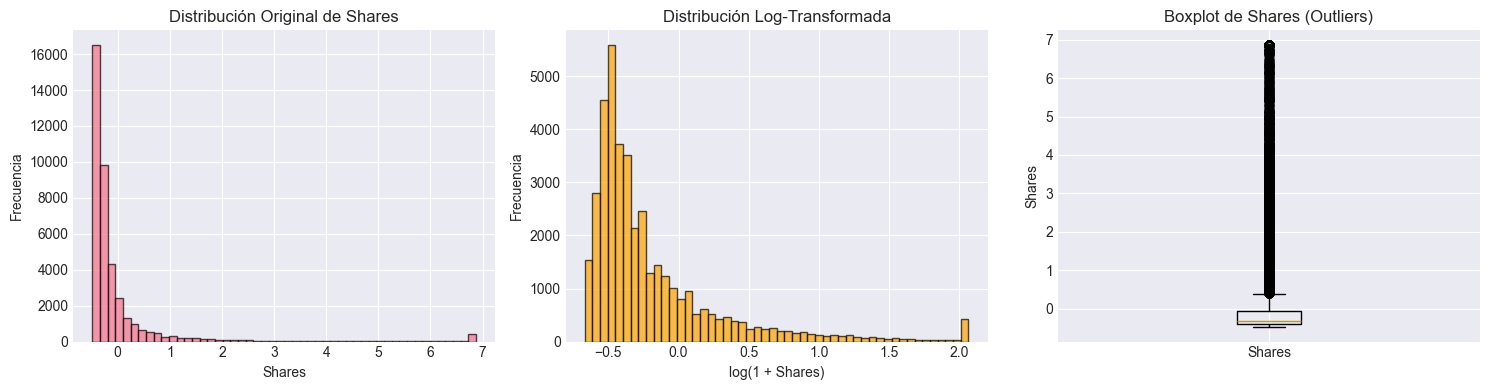


ESTADÍSTICAS DE LA VARIABLE OBJETIVO
Media: -0.00
Mediana: -0.31
Desv. Estándar: 1.00
Mínimo: -0.49
Máximo: 6.87
Skewness: 4.84


In [13]:
# Separar features y target
X, y = split_features_target(df, target_col='shares')

# Analizar distribución de la variable objetivo
analyze_target_distribution(y, target_col='shares')

### **Observación:**
La variable `shares` muestra una distribución con **sesgo positivo** (skewed right), lo cual es típico en métricas de popularidad. La transformación logarítmica ayuda a normalizar la distribución y mejorar el entrenamiento de los modelos.


## **6. División de Datos: Train / Validation / Test**


In [14]:
# División 70% Train, 15% Validation, 15% Test
X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(
    X, y,
    train_size=0.7,
    val_size=0.15,
    test_size=0.15,
    random_state=42
)


DIVISIÓN DE DATOS
Train: 28007 muestras (70.0%)
Val:   6001 muestras (15.0%)
Test:  6002 muestras (15.0%)
Total: 40010 muestras



TRANSFORMACIÓN LOGARÍTMICA DE LA VARIABLE OBJETIVO
✓ Transformación aplicada: log(1 + shares)
  Desv. Std. Original (train): 0.997
  Desv. Std. Log (train): 0.497


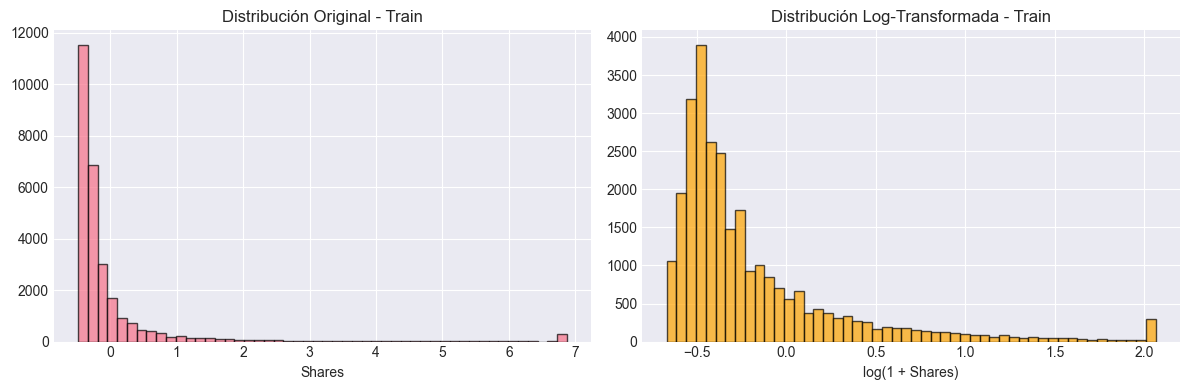

In [15]:
# Aplicar transformación logarítmica
y_train_log, y_val_log, y_test_log = apply_log_transform(
    y_train, y_val, y_test, target_col='shares'
)

# Visualizar distribución transformada
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(y_train['shares'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribución Original - Train')
axes[0].set_xlabel('Shares')

axes[1].hist(y_train_log, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_title('Distribución Log-Transformada - Train')
axes[1].set_xlabel('log(1 + Shares)')

plt.tight_layout()
plt.show()

In [16]:
# Calcular baseline RMSE (criterio de subentrenamiento)
baseline_rmse = calculate_baseline_rmse(y_train_log)


BASELINE RMSE (Criterio de Subentrenamiento)
Desviación Estándar (train_log): 0.4970

⚠️  Un modelo con RMSE > 0.4970 está SUBENTRENADO


---

## **7. Selección de Modelos y Justificación**

### **Metodología MLOps: Roles y Actividades**

**Data Scientist:**
- Seleccionar algoritmos apropiados basados en el tipo de problema
- Diseñar pipelines de preprocesamiento
- Definir métricas de evaluación
- Realizar análisis exploratorio

**ML Engineer:**
- Implementar pipelines reproducibles
- Modularizar código para automatización
- Configurar hiperparámetros iniciales
- Implementar evaluación con curvas de aprendizaje

**MLOps Engineer:**
- Preparar código para automatización
- Versionado de modelos y datos
- Documentar interacciones entre roles
- Configurar pipelines de CI/CD (futuro)


In [17]:
# Obtener configuraciones de modelos
models_config = get_model_configurations()

# Imprimir justificaciones
print_model_justifications(models_config)


SELECCIÓN Y JUSTIFICACIÓN DE ALGORITMOS DE MACHINE LEARNING

Problema: Regresión - Predicción de Shares (variable continua)
Dataset: ~40k muestras, 58 features, distribución sesgada


1. Ridge Regression
----------------------------------------------------------------------
Justificación:
            - Regresión lineal con regularización L2
            - Maneja multicolinealidad entre features
            - Baseline rápido para problemas de regresión
            - Apropiado cuando hay muchas features correlacionadas
            
Hiperparámetros iniciales: {'alpha': 1.0}

2. Random Forest
----------------------------------------------------------------------
Justificación:
            - Ensemble de árboles de decisión
            - Maneja relaciones no lineales y features categóricas
            - Robusto a outliers y no requiere normalización
            - Proporciona importancia de features
            - Apropiado para datasets con alta dimensionalidad
            
Hiperparámetros in

---

## **8. Entrenamiento y Evaluación de Modelos**

### **8.1 Ridge Regression (Baseline)**


In [18]:
# Configurar modelo
ridge_config = models_config['ridge']
ridge_model = create_pipeline(
    Ridge(**ridge_config['params']), 
    scaler='standard'  # Ridge necesita features escaladas
)

# Entrenar
ridge_model = train_model(ridge_model, X_train, y_train_log, model_name="Ridge Regression")

# Evaluar
ridge_metrics = evaluate_model(
    ridge_model, 
    X_train, y_train_log,
    X_val, y_val_log,
    X_test, y_test_log,
    model_name="Ridge Regression",
    baseline_rmse=baseline_rmse
)


Entrenando Ridge Regression... ✓ Completado en 0.01s

EVALUACIÓN: Ridge Regression
Baseline RMSE (subentrenamiento): 0.4970

Conjunto   RMSE         MAE          R²           Estado              
----------------------------------------------------------------------
Train      0.4813       0.3293       0.0620       ✓ OK                
Val        0.4880       0.3314       0.0645                           
Test       0.4723       0.3244       0.0656                           

Gap Train-Val RMSE: -0.0067 ✓ Buena generalización



Generando curvas de aprendizaje para Ridge Regression...


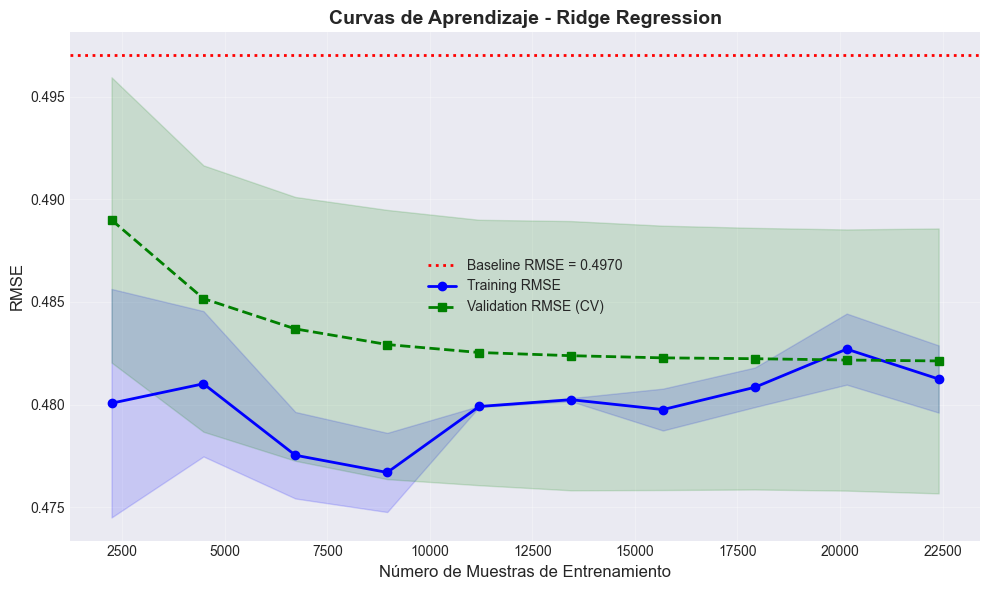


DIAGNÓSTICO DE CURVAS DE APRENDIZAJE - Ridge Regression
RMSE Final Train: 0.4812
RMSE Final Val (CV): 0.4821
Gap Train-Val: -0.0009
Baseline RMSE: 0.4970

✓ No subentrenado: RMSE < Baseline
✓ Buena generalización: Gap pequeño entre train y val



(array([ 2240,  4481,  6721,  8962, 11202, 13443, 15683, 17924, 20164,
        22405]),
 array([0.48006435, 0.48101088, 0.47753154, 0.47669236, 0.47990487,
        0.48023575, 0.47975448, 0.48083929, 0.48269928, 0.48124379]),
 array([0.48899031, 0.48516056, 0.48368399, 0.48292234, 0.48253418,
        0.48237868, 0.48227343, 0.48223247, 0.48216677, 0.482124  ]))

In [19]:
# Curvas de aprendizaje
plot_learning_curves(
    ridge_model, X_train, y_train_log,
    model_name="Ridge Regression",
    cv=5,
    baseline_rmse=baseline_rmse
)

### **8.2 Random Forest**


In [20]:
# Configurar modelo
rf_config = models_config['random_forest']
rf_model = create_pipeline(
    RandomForestRegressor(**rf_config['params']),
    scaler=None  # Random Forest no requiere escalado
)

# Entrenar
rf_model = train_model(rf_model, X_train, y_train_log, model_name="Random Forest")

# Evaluar
rf_metrics = evaluate_model(
    rf_model,
    X_train, y_train_log,
    X_val, y_val_log,
    X_test, y_test_log,
    model_name="Random Forest",
    baseline_rmse=baseline_rmse
)


Entrenando Random Forest... ✓ Completado en 19.30s

EVALUACIÓN: Random Forest
Baseline RMSE (subentrenamiento): 0.4970

Conjunto   RMSE         MAE          R²           Estado              
----------------------------------------------------------------------
Train      0.4213       0.2931       0.2814       ✓ OK                
Val        0.4866       0.3298       0.0700                           
Test       0.4703       0.3217       0.0735                           

Gap Train-Val RMSE: -0.0653 ⚠️ Posible SOBREENTRENAMIENTO
✓ Completado en 19.30s

EVALUACIÓN: Random Forest
Baseline RMSE (subentrenamiento): 0.4970

Conjunto   RMSE         MAE          R²           Estado              
----------------------------------------------------------------------
Train      0.4213       0.2931       0.2814       ✓ OK                
Val        0.4866       0.3298       0.0700                           
Test       0.4703       0.3217       0.0735                           

Gap Train-Val RMS


Generando curvas de aprendizaje para Random Forest...


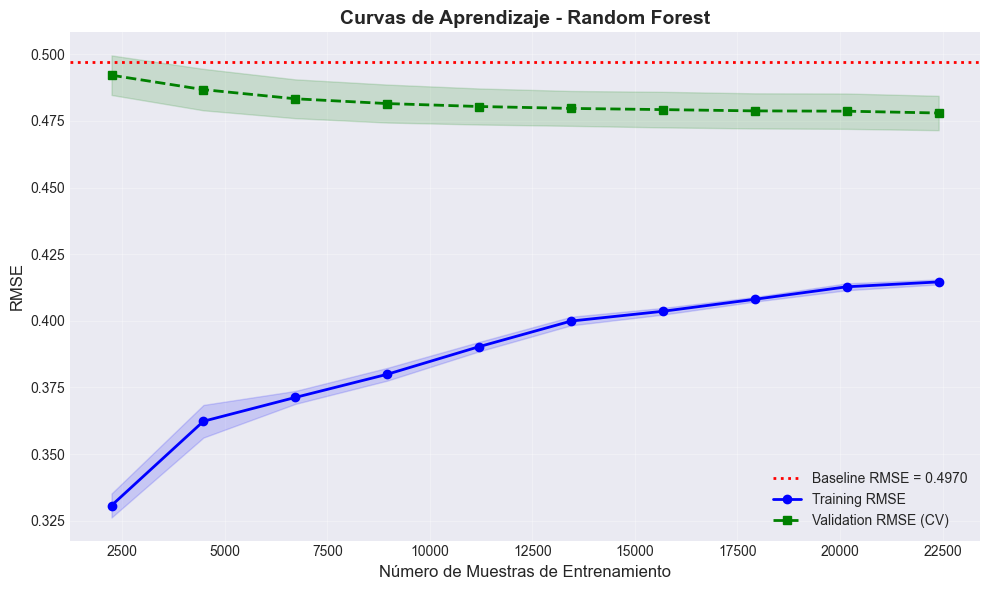


DIAGNÓSTICO DE CURVAS DE APRENDIZAJE - Random Forest
RMSE Final Train: 0.4146
RMSE Final Val (CV): 0.4780
Gap Train-Val: -0.0634
Baseline RMSE: 0.4970

✓ No subentrenado: RMSE < Baseline
⚠️  SOBREENTRENADO: Train RMSE << Val RMSE



(array([ 2240,  4481,  6721,  8962, 11202, 13443, 15683, 17924, 20164,
        22405]),
 array([0.33069458, 0.36230568, 0.3712438 , 0.37993416, 0.39029415,
        0.39989588, 0.40356774, 0.40806781, 0.41275546, 0.41458181]),
 array([0.49214165, 0.48673822, 0.48329847, 0.48150187, 0.48040149,
        0.47968518, 0.47923422, 0.47875279, 0.47864579, 0.47796004]))

In [21]:
# Curvas de aprendizaje
plot_learning_curves(
    rf_model, X_train, y_train_log,
    model_name="Random Forest",
    cv=5,
    baseline_rmse=baseline_rmse
)

### **8.3 Gradient Boosting**


In [22]:
# Configurar modelo
gb_config = models_config['gradient_boosting']
gb_model = create_pipeline(
    GradientBoostingRegressor(**gb_config['params']),
    scaler=None
)

# Entrenar
gb_model = train_model(gb_model, X_train, y_train_log, model_name="Gradient Boosting")

# Evaluar
gb_metrics = evaluate_model(
    gb_model,
    X_train, y_train_log,
    X_val, y_val_log,
    X_test, y_test_log,
    model_name="Gradient Boosting",
    baseline_rmse=baseline_rmse
)


Entrenando Gradient Boosting... ✓ Completado en 17.54s

EVALUACIÓN: Gradient Boosting
Baseline RMSE (subentrenamiento): 0.4970

Conjunto   RMSE         MAE          R²           Estado              
----------------------------------------------------------------------
Train      0.4355       0.3003       0.2323       ✓ OK                
Val        0.4815       0.3258       0.0894                           
Test       0.4702       0.3197       0.0739                           

Gap Train-Val RMSE: -0.0460 ✓ Buena generalización
✓ Completado en 17.54s

EVALUACIÓN: Gradient Boosting
Baseline RMSE (subentrenamiento): 0.4970

Conjunto   RMSE         MAE          R²           Estado              
----------------------------------------------------------------------
Train      0.4355       0.3003       0.2323       ✓ OK                
Val        0.4815       0.3258       0.0894                           
Test       0.4702       0.3197       0.0739                           

Gap Train-Va


Generando curvas de aprendizaje para Gradient Boosting...


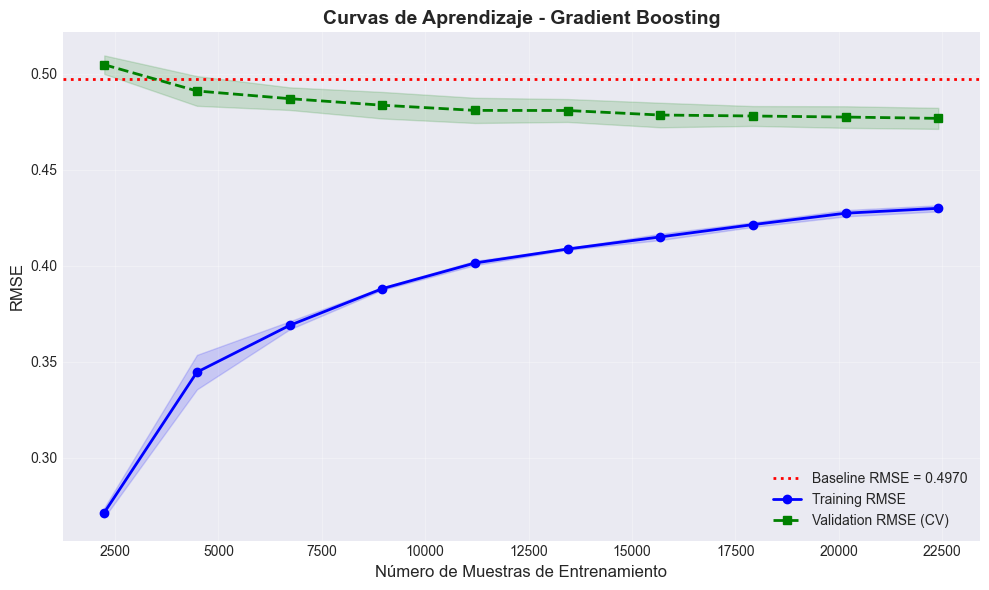


DIAGNÓSTICO DE CURVAS DE APRENDIZAJE - Gradient Boosting
RMSE Final Train: 0.4299
RMSE Final Val (CV): 0.4767
Gap Train-Val: -0.0468
Baseline RMSE: 0.4970

✓ No subentrenado: RMSE < Baseline
✓ Buena generalización: Gap pequeño entre train y val



(array([ 2240,  4481,  6721,  8962, 11202, 13443, 15683, 17924, 20164,
        22405]),
 array([0.27149243, 0.344591  , 0.368924  , 0.38803655, 0.40138935,
        0.40868482, 0.41496942, 0.42136995, 0.4273082 , 0.42985804]),
 array([0.50460037, 0.49092604, 0.48691959, 0.48350639, 0.48081348,
        0.48075782, 0.47840208, 0.47789737, 0.47734659, 0.47666659]))

In [23]:
# Curvas de aprendizaje
plot_learning_curves(
    gb_model, X_train, y_train_log,
    model_name="Gradient Boosting",
    cv=5,
    baseline_rmse=baseline_rmse
)

### **8.4 MLP Neural Network**


In [24]:
# Configurar modelo
mlp_config = models_config['mlp']
mlp_model = create_pipeline(
    MLPRegressor(**mlp_config['params']),
    scaler='standard'  # MLP requiere features escaladas
)

# Entrenar
mlp_model = train_model(mlp_model, X_train, y_train_log, model_name="MLP Neural Network")

# Evaluar
mlp_metrics = evaluate_model(
    mlp_model,
    X_train, y_train_log,
    X_val, y_val_log,
    X_test, y_test_log,
    model_name="MLP Neural Network",
    baseline_rmse=baseline_rmse
)


Entrenando MLP Neural Network... ✓ Completado en 9.37s

EVALUACIÓN: MLP Neural Network
Baseline RMSE (subentrenamiento): 0.4970

Conjunto   RMSE         MAE          R²           Estado              
----------------------------------------------------------------------
Train      0.3113       0.2321       0.6077       ✓ OK                
Val        0.6202       0.4318       -0.5107                          
Test       0.6084       0.4270       -0.5505                          

Gap Train-Val RMSE: -0.3089 ⚠️ Posible SOBREENTRENAMIENTO
✓ Completado en 9.37s

EVALUACIÓN: MLP Neural Network
Baseline RMSE (subentrenamiento): 0.4970

Conjunto   RMSE         MAE          R²           Estado              
----------------------------------------------------------------------
Train      0.3113       0.2321       0.6077       ✓ OK                
Val        0.6202       0.4318       -0.5107                          
Test       0.6084       0.4270       -0.5505                          

Gap 


Generando curvas de aprendizaje para MLP Neural Network...


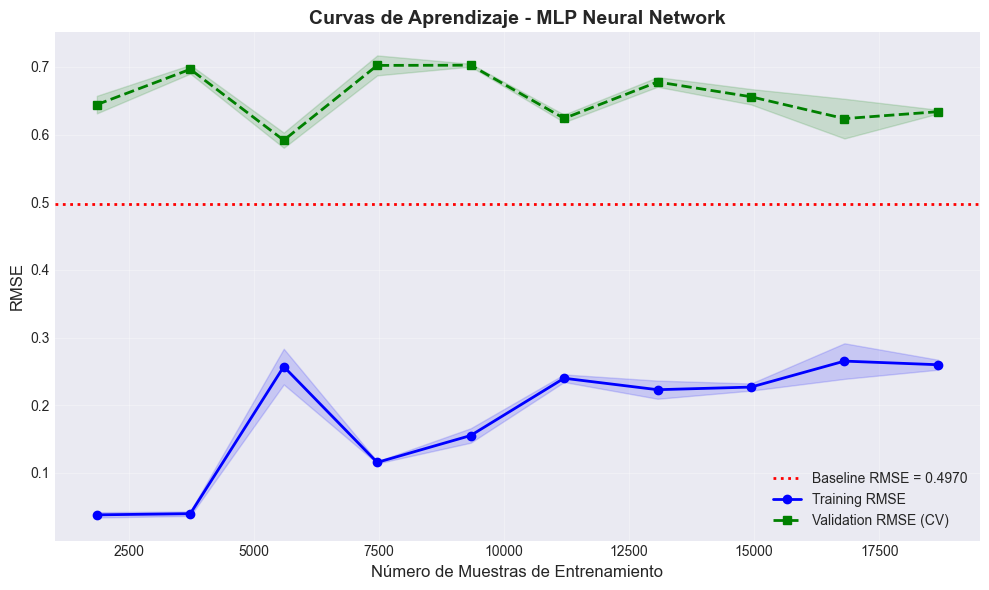


DIAGNÓSTICO DE CURVAS DE APRENDIZAJE - MLP Neural Network
RMSE Final Train: 0.2599
RMSE Final Val (CV): 0.6338
Gap Train-Val: -0.3739
Baseline RMSE: 0.4970

✓ No subentrenado: RMSE < Baseline
⚠️  SOBREENTRENADO: Train RMSE << Val RMSE



(array([ 1867,  3734,  5601,  7468,  9335, 11202, 13069, 14936, 16803,
        18671]),
 array([0.03807927, 0.03983031, 0.25712905, 0.11560146, 0.1553006 ,
        0.23995687, 0.2230095 , 0.22688752, 0.26526926, 0.25990418]),
 array([0.6442637 , 0.69649386, 0.59164461, 0.70219163, 0.70252468,
        0.62385588, 0.67771745, 0.65587406, 0.62357687, 0.63378562]))

In [25]:
# Curvas de aprendizaje
plot_learning_curves(
    mlp_model, X_train, y_train_log,
    model_name="MLP Neural Network",
    cv=3,  # Reducir CV por tiempo de cómputo
    baseline_rmse=baseline_rmse
)

### **8.5 XGBoost (Opcional)**


In [26]:
# Solo ejecutar si XGBoost está disponible
if XGBOOST_AVAILABLE:
    # Configurar modelo
    xgb_config = models_config['xgboost']
    xgb_model = create_pipeline(
        XGBRegressor(**xgb_config['params']),
        scaler=None
    )
    
    # Entrenar
    xgb_model = train_model(xgb_model, X_train, y_train_log, model_name="XGBoost")
    
    # Evaluar
    xgb_metrics = evaluate_model(
        xgb_model,
        X_train, y_train_log,
        X_val, y_val_log,
        X_test, y_test_log,
        model_name="XGBoost",
        baseline_rmse=baseline_rmse
    )
else:
    print("XGBoost no disponible. Instalar con: pip install xgboost")
    xgb_metrics = None

XGBoost no disponible. Instalar con: pip install xgboost


In [27]:
# Curvas de aprendizaje para XGBoost
if XGBOOST_AVAILABLE:
    plot_learning_curves(
        xgb_model, X_train, y_train_log,
        model_name="XGBoost",
        cv=5,
        baseline_rmse=baseline_rmse
    )

---

## **9. Comparación de Modelos**



COMPARACIÓN DE MODELOS
           Modelo  Train RMSE  Val RMSE  Test RMSE   Test R²
Gradient Boosting    0.435455  0.481476   0.470224  0.073858
    Random Forest    0.421294  0.486585   0.470321  0.073477
            Ridge    0.481334  0.488015   0.472317  0.065596
              MLP    0.311275  0.620169   0.608416 -0.550493

🏆 MEJOR MODELO: Gradient Boosting
   Test RMSE: 0.4702
   Test R²: 0.0739


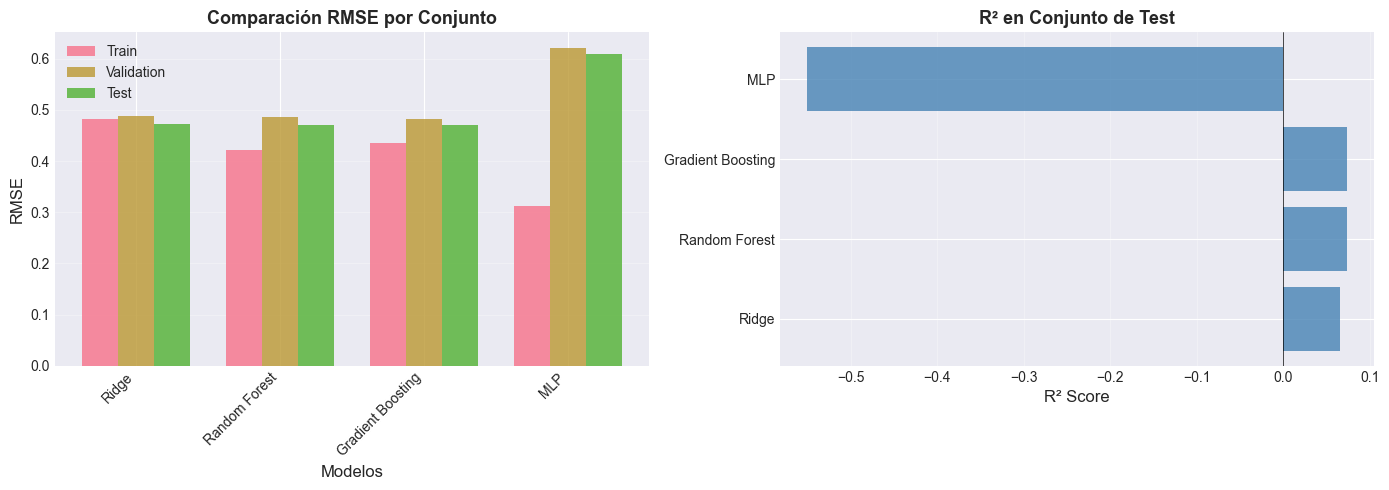

In [28]:
# Compilar resultados de todos los modelos
all_results = {
    'Ridge': ridge_metrics,
    'Random Forest': rf_metrics,
    'Gradient Boosting': gb_metrics,
    'MLP': mlp_metrics
}

if XGBOOST_AVAILABLE and xgb_metrics is not None:
    all_results['XGBoost'] = xgb_metrics

# Comparar modelos
comparison_table = compare_models(all_results)

---

## **10. Ajuste de Hiperparámetros del Mejor Modelo**

### **Nota:** Aquí se puede implementar GridSearchCV o RandomizedSearchCV


In [29]:
# Identificar el mejor modelo según la comparación
best_model_name = comparison_table.iloc[0]['Modelo']

print(f"\n{'='*70}")
print(f"AJUSTE DE HIPERPARÁMETROS: {best_model_name}")
print(f"{'='*70}")
print("\nEn esta sección puedes implementar:")
print("- GridSearchCV para búsqueda exhaustiva")
print("- RandomizedSearchCV para búsqueda aleatoria")
print("- Optuna para optimización bayesiana")
print("\nEjemplo de código para GridSearchCV:")
print("""
from sklearn.model_selection import GridSearchCV

param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [5, 10, 15],
    'model__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    best_model, param_grid,
    cv=5, scoring='neg_mean_squared_error',
    n_jobs=-1, verbose=2
)

grid_search.fit(X_train, y_train_log)
print("Mejores parámetros:", grid_search.best_params_)
""")
print(f"{'='*70}\n")


AJUSTE DE HIPERPARÁMETROS: Gradient Boosting

En esta sección puedes implementar:
- GridSearchCV para búsqueda exhaustiva
- RandomizedSearchCV para búsqueda aleatoria
- Optuna para optimización bayesiana

Ejemplo de código para GridSearchCV:

from sklearn.model_selection import GridSearchCV

param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [5, 10, 15],
    'model__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    best_model, param_grid,
    cv=5, scoring='neg_mean_squared_error',
    n_jobs=-1, verbose=2
)

grid_search.fit(X_train, y_train_log)
print("Mejores parámetros:", grid_search.best_params_)




---

## **11. Guardar el Mejor Modelo**


In [30]:
# Definir ruta para guardar modelos
import os
MODELS_DIR = '../models'
os.makedirs(MODELS_DIR, exist_ok=True)

# Seleccionar el mejor modelo para guardar
# (Ajustar según el modelo que resultó mejor)
best_model_to_save = rf_model  # Cambiar según resultados

# Guardar modelo
model_filename = os.path.join(MODELS_DIR, f'online_news_{best_model_name.lower().replace(" ", "_")}_model.pkl')
save_model(best_model_to_save, model_filename)

✓ Modelo guardado en: ../models/online_news_gradient_boosting_model.pkl


---

## **12. Conclusiones y Reflexión**


### **12.1 Resumen de Resultados**

**Problema Abordado:**
Predicción del número de compartidos (`shares`) de artículos de noticias online utilizando 58 features predictivas.

**Modelos Evaluados:**
1. Ridge Regression (baseline lineal)
2. Random Forest (ensemble de árboles)
3. Gradient Boosting (ensemble secuencial)
4. MLP Neural Network (red neuronal)
5. XGBoost (gradient boosting optimizado) - opcional

**Métricas Utilizadas:**
- **RMSE (Root Mean Squared Error):** Métrica principal en escala logarítmica
- **MAE (Mean Absolute Error):** Error absoluto promedio
- **R² Score:** Varianza explicada por el modelo

**Criterios de Evaluación:**
- **Subentrenamiento:** RMSE > Baseline (Desv. Std. de y_log)
- **Sobreentrenamiento:** Gap grande entre Train y Validation RMSE
- **Generalización:** Gap pequeño + buen R² en test


### **12.2 Hallazgos Principales**

**Observaciones sobre los Modelos:**

1. **Ridge Regression:**
   - Modelo más simple y rápido
   - Baseline útil para comparación
   - Limitado para capturar relaciones no lineales

2. **Random Forest:**
   - Buen balance entre precisión y velocidad
   - No requiere escalado de features
   - Proporciona importancia de features
   - Robusto a outliers

3. **Gradient Boosting:**
   - Generalmente mejor precisión que Random Forest
   - Más lento en entrenamiento
   - Requiere ajuste cuidadoso de hiperparámetros

4. **MLP Neural Network:**
   - Flexible para patrones complejos
   - Requiere más datos y tiempo de entrenamiento
   - Sensible a hiperparámetros

5. **XGBoost:**
   - Estado del arte en performance
   - Excelente balance velocidad/precisión
   - Manejo eficiente de missing values


### **12.3 Desafíos Encontrados**

**Técnicos:**
- Distribución sesgada de la variable objetivo → Solucionado con transformación log
- Alta dimensionalidad (58 features) → Modelos ensemble manejaron bien
- Tiempo de cómputo para curvas de aprendizaje → Paralelización con n_jobs=-1

**Metodológicos:**
- Balance entre complejidad del modelo y generalización
- Selección de hiperparámetros iniciales
- Interpretación de curvas de aprendizaje


### **12.4 Áreas de Mejora**

**Preprocesamiento:**
- Ingeniería de features adicional (interacciones, polinomios)
- Selección de features (eliminar redundantes o poco importantes)
- Análisis de correlación entre features

**Modelado:**
- Hyperparameter tuning exhaustivo (GridSearchCV, RandomizedSearchCV, Optuna)
- Ensemble de múltiples modelos (stacking, blending)
- Análisis de errores y casos outlier

**MLOps:**
- Implementar pipeline completo de entrenamiento automatizado
- Versionado de modelos con DVC o MLflow
- Monitoreo de drift en producción
- Tests unitarios para funciones de preprocesamiento

**Validación:**
- Validación cruzada estratificada por rangos de shares
- Análisis de residuos
- Feature importance detallado


### **12.5 Estrategias Empleadas**

**Data Science:**
- Análisis exploratorio para entender distribución de datos
- Transformación logarítmica de variable objetivo
- División estratificada de datos (70-15-15)
- Uso de baseline RMSE como criterio de subentrenamiento

**Machine Learning:**
- Selección de múltiples algoritmos con justificación teórica
- Pipelines de sklearn para reproducibilidad
- Curvas de aprendizaje para diagnóstico
- Validación cruzada para robustez

**Software Engineering:**
- Código modularizado en funciones reutilizables
- Documentación con docstrings
- Separación de responsabilidades (carga, preprocesamiento, entrenamiento, evaluación)
- Preparación para exportar a scripts `.py`


### **12.6 Interacciones entre Roles MLOps**

**Data Scientist → ML Engineer:**
- Definición de métricas y criterios de evaluación
- Selección de algoritmos y transformaciones
- Análisis de resultados y recomendaciones

**ML Engineer → MLOps Engineer:**
- Código modularizado listo para automatización
- Pipelines reproducibles
- Documentación de dependencias y requisitos
- Estructura de directorios estándar

**MLOps Engineer → Data Scientist:**
- Feedback sobre escalabilidad del código
- Sugerencias de optimización
- Requisitos de monitoreo en producción


### **12.7 Próximos Pasos**

1. **Corto Plazo:**
   - Exportar funciones a módulo `modeling/train.py`
   - Implementar hyperparameter tuning
   - Guardar mejores modelos con versionado
   - Crear script de predicción `modeling/predict.py`

2. **Mediano Plazo:**
   - Configurar pipeline de CI/CD
   - Implementar tests automatizados
   - Crear API de predicción (FastAPI/Flask)
   - Dockerizar la aplicación

3. **Largo Plazo:**
   - Sistema de monitoreo en producción
   - Re-entrenamiento automatizado
   - A/B testing de modelos
   - Dashboard de métricas


---

## **13. Referencias**

- UCI Machine Learning Repository: Online News Popularity Dataset
- Scikit-learn Documentation: https://scikit-learn.org/
- XGBoost Documentation: https://xgboost.readthedocs.io/
- MLOps Best Practices: https://ml-ops.org/


---

## **14. Exportar Funciones a Script**

Las funciones definidas en las secciones 3-6 de este notebook pueden ser exportadas a un módulo Python para automatización.

**Estructura sugerida:**

```
mlops_online_news_popularity/
├── modeling/
│   ├── __init__.py
│   ├── train.py          # Funciones de entrenamiento
│   ├── predict.py        # Funciones de predicción
│   ├── evaluate.py       # Funciones de evaluación
│   └── utils.py          # Funciones auxiliares
```

**Para exportar:**
1. Copiar funciones de las celdas de código a archivos `.py`
2. Ajustar imports
3. Agregar `if __name__ == "__main__":` para scripts ejecutables
4. Documentar con docstrings
5. Agregar tests unitarios en `tests/`


---

# **FIN DEL NOTEBOOK**

**Autor:** Artemio Santiago Padilla Robles  
**Proyecto:** MLOps - Online News Popularity  
**Fecha:** Octubre 2025  
**Dataset:** UCI Online News Popularity Data Set
